In [464]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

In [465]:
np.random.seed(0) #We set seed to ensure results are reproducible

# 1.1 1a)
For each of the polynomial bases of dimension k = 1, 2, 3, 4 fit the data set of Figure 1 {(1, 3),(2, 2),(3, 0),(4, 5)}.

In [466]:
def polyn_map(X, k = 1):
  #takes input data X and transforms X to polynomial basis of dimension k with bias term. 
    if X.ndim == 1:
        X = X.reshape(X.size,1)
    m,n = X.shape
    Z = X
    for i in range(k): #calculate each polynomial column and append them to Z iteratively
        pol = (X[:,0]**i).reshape(m,1) #raise X to ith power
        if i == 0:
            Z = pol
        else:
            Z = np.hstack([Z, pol]) #append polynomial column i to Z

    return Z

In [467]:
def fit_curve(X, y, k, f_map = polyn_map):
    #transforms data X to Z then solves least squares solution for Z and y, returning coefficients w
    Z = f_map(X, k)
    mz, nz = Z.shape

    w = ((np.linalg.inv(Z.T @ Z)) @ Z.T @ y).reshape(nz, 1)
    return w
#note this function wasn't used for solving when the dimension of the polynomial basis was large due to numerical issues. np.linalg.lstsq() was used instead

In [468]:
def plot_linreg(X, y, ks, b = 5, f_map = polyn_map, y_limit = False):
    #this function fits a least squares linear regression model to data transformed by the function f_map to a basis determined by the parameter 'ks'
    #it then predicts a y value for a range of X values (also transformed) to give us the curve of best fit
    #this curve is then plotted with the points in our dataset superimposed on top. 
    
  
    y_hats = []
    colours = ['r', 'b', 'g', 'y', 'pink'] #if we want to plot multiple curves
    X2 = np.arange(0,b,step=0.005) #generate X coordinates for plotting curve
    
    #plot formatting
    plt.subplots(figsize = (10,10))
    plt.scatter(x = X, y = y) # plot points in the dataset given to us in the assignment
    custom_lines = [(Line2D([0], [0], color=colours[k], lw=4)) for k in range(len(ks))]

    
    
    for k_ind in range(len(ks)):
        Z2 = f_map(X2, ks[k_ind]) #transform points for plotting curves (range of X values from 0 to b)

        Z = f_map(X, ks[k_ind]) #transform points for fitting (X values given in the assignment)



        #we use np.linalg.lstsq to find least squares solution for transformed data Z. This function is equivalent to solving the least squares solution 'w' for the equation y = wZ 
        #note that if Z isn't invertible, np.linalg.lstsq minimises the euclidean 2-norm ||y - wZ||
        w = np.linalg.lstsq(Z, y, rcond = None)[0]
       
       
        y_hats.append([w.T @ Z2[i,:] for i in range(Z2.shape[0])]) # predict points to plot, append them to list of predictions

        #now have all our predictions, we can plot them. 
        if ks[k_ind] == 1: 
            plt.plot(X2, y_hats[k_ind], c = colours[k_ind])

        else:
            plt.plot(Z2[:,1], y_hats[k_ind], c = colours[k_ind])
    plt.title('')
    plt.legend(custom_lines, [f'k = {ks[k_ind]}' for k_ind in range(len(ks))], fontsize = 10)
    plt.xlabel('X', fontsize = 15)
    plt.ylabel('Y')
    if y_limit:
      ax = plt.gca()
      ax.set_ylim([-0.3,2.5]) #high polynomial curves tend to veer off high near 0 or 1, limit the y axis values to make sure the plot doesn't zoom out too much
    plt.show()

In [469]:
ds = np.array([[1,3], [2,2], [3,0], [4,5]]) #define dataset as given in the assignment
X = ds[:,0]
y = ds[:,1]

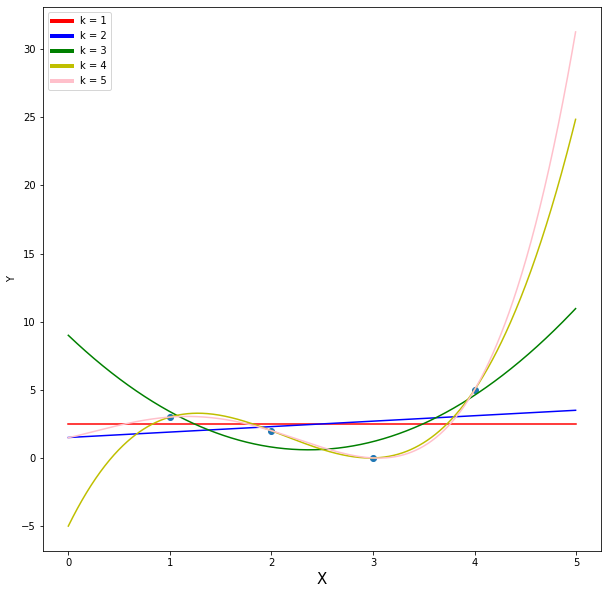

In [470]:
plot_linreg(X, y, [1,2,3,4,5])

# 1.1 1b) 


In [471]:
#return w for each of k = 1,2,3. These give the coefficients for the equations of the curves in x.
for i in range(1,5):
  print(f'k = {i}, w = ', fit_curve(X, y, i))


k = 1, w =  [[2.5]]
k = 2, w =  [[1.5]
 [0.4]]
k = 3, w =  [[ 9. ]
 [-7.1]
 [ 1.5]]
k = 4, w =  [[-5.        ]
 [15.16666667]
 [-8.5       ]
 [ 1.33333333]]


k = 1: 2.5  
k = 2: 1.5 +0.4x  
k = 3: 9 -7.1x + 1.5(x^2)

#1.1 1c)

In [472]:
def mse_test(X, y, k, X_test = None, y_test = None, f_map = polyn_map):
    #returns mean squared error for a curve fitted for basis dimension k = k on X_train, and either evaluated on X_train or X_test


    Z = f_map(X, k) # transform basis of X with feature map f_map
    m = X.size 
    w = np.linalg.lstsq(Z, y,rcond=None)[0] #solve least squares problem for transformed data

    if X_test is not None: #if we have test data, transform test data, predict y_test and return test MSE
        Z_test = f_map(X_test, k) 
        y_hat = np.array([w.T @ Z_test[i,:] for i in range(Z_test.shape[0])]).reshape(y_test.shape) 
        MSE = np.sum((y_test - y_hat)**2)/X_test.size 
        return MSE
    else: #if no test data, predict y_train and calculate training mse
        y_hat = np.array([w.T @ Z[i,:] for i in range(Z.shape[0])]).reshape(y.shape)
        MSE = np.sum((y - y_hat)**2)/m
        return MSE


In [473]:
#mse for each k
for k in range(1,5):
    print(f'The MSE for curve with k = {k} is ', mse_test(X, y, k))

The MSE for curve with k = 1 is  3.25
The MSE for curve with k = 2 is  3.05
The MSE for curve with k = 3 is  0.7999999999999999
The MSE for curve with k = 4 is  9.03927361603976e-27


# 1.1 2a)i)

In [474]:
def g(X, sig = False):
    #function that returns sin squared of x with added noise epsilon 
    m = X.size
    noise_vec = 0
    if sig:
        noise_vec = np.random.normal(0, 0.07, m)
    return np.sin(2*np.pi*X)**2 + noise_vec


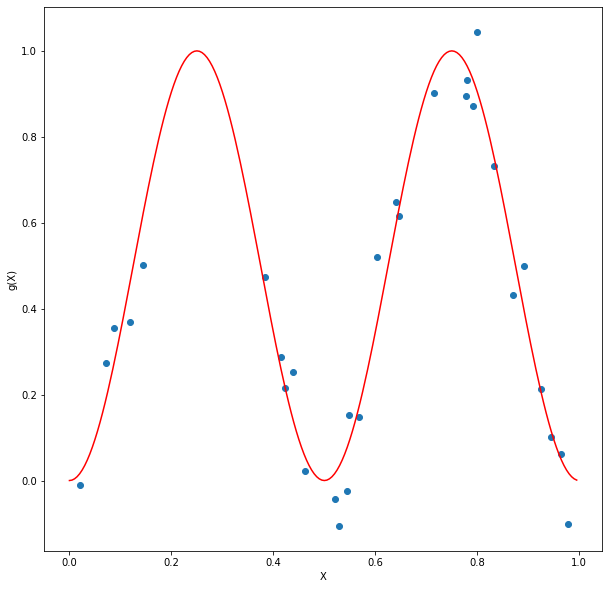

In [475]:
#sample and plot data

X = np.random.uniform(size = 30) # sample X uniformly from [0,1)
X2 = np.arange(0,1,step=0.005) #generate X for plotting curve
g_X = g(X, sig = 0.07)
plt.subplots(figsize = (10,10))
plt.plot(X2, g(X2), c = 'r') # plot curve
plt.scatter(X, g_X) #plot point
plt.xlabel('X')
plt.ylabel('g(X)')

plt.show()


# 1.1 2a)ii)

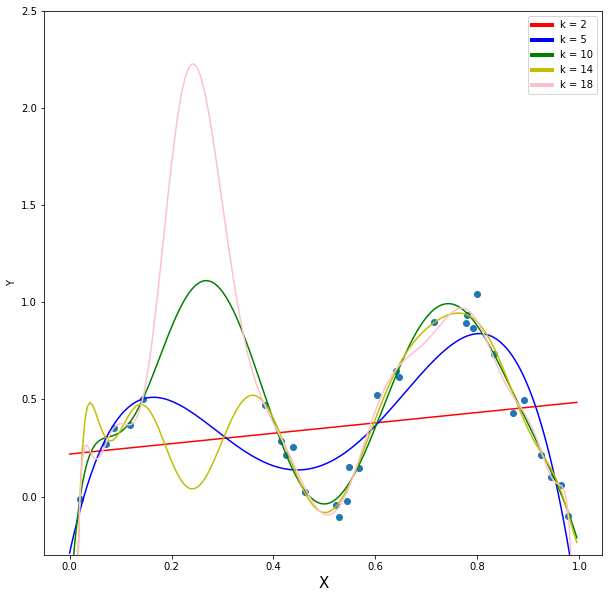

In [476]:
#plot fitted curves for polynomial bases k = 2,5,10,14,18
ks = [2,5,10,14,18]
plot_linreg(X, g_X, ks, b = 1, y_limit = True)

# 1.1 2b)

In [477]:
#fit curves and calculate training error for polynomial bases 1 - 18

training_error = np.array([mse_test(X, g_X, k) for k in range(1,19)])


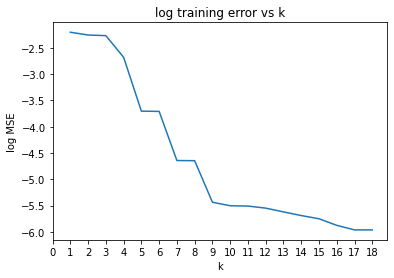

In [478]:
#plot natural log of training MSE vs k  
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(training_error))
ax.set_title('log training error vs k')
ax.set_ylabel('log MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
plt.show()

# 1.1 2c)

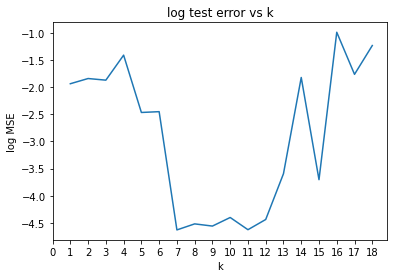

In [479]:
#calculate and plot log test MSE for polynomial bases dimension 1 to 19
X_test = np.random.uniform(size = 1000) #generate test set X
g_X_test = g(X_test, sig = 0.07) # generate y (g(X)) for test set
test_error = np.array([mse_test(X, g_X, k, X_test, g_X_test) for k in range(1,19)]) # calculate mse on test set for k = 1,...,18
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(test_error))
ax.set_title('log test error vs k')
ax.set_ylabel('log MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
plt.show()


# 1.1 2d)

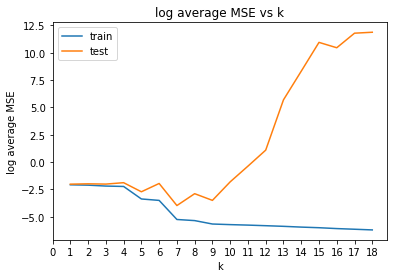

In [480]:
#MSE average for polynomial basis 
test_mse_avg = np.zeros(shape = (18,))
train_mse_avg = np.zeros(shape = (18,))
for iter in range(100):#for each run generate 30 training points, 1000 test points, fit curve for k = 1,...,18 on the training data, calculate training MSE then calculate MSE of fit on the test set
  X = np.random.uniform(size = 30) 
  g_X = g(X, sig = 0.07)
  X_test = np.random.uniform(size = 1000) 
  g_X_test = g(X_test, 0.07)
  
  training_error = np.array([mse_test(X, g_X, k) for k in range(1,19)]) # fit curves for different k and calculate training MSE
  training_error /= 100 #divide error by number of runs (100) so we can sum them to get our average training error
  train_mse_avg += training_error 
  
  test_error = np.array([mse_test(X, g_X, k, X_test, g_X_test) for k in range(1,19)]) 
  test_error /= 100 
  test_mse_avg += test_error 

#plot results
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(train_mse_avg), label = 'train')  
ax.plot(list(range(1,19)), np.log(test_mse_avg), label = 'test')

ax.set_title('log average MSE vs k')
ax.set_ylabel('log average MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
ax.legend()
plt.show()

# 1.1 3

In [481]:
def sin_map(X, k = 1):
  #takes input data X and transforms X to basis {sin(1*pi*x),...,sin(k*pi*x)} of dimension k
  if X.ndim == 1:
    X = X.reshape(X.size,1)
  m,n = X.shape
  Z = np.sin(np.pi * X) #first set Z to the basis sin(pi*x)
  for i in range(2, k+1):
    sine = np.sin(i * np.pi * X[:,0]).reshape(m,1) #calculate the term for k = i
    Z = np.hstack([Z, sine]) #append this new term to Z
  
  return Z


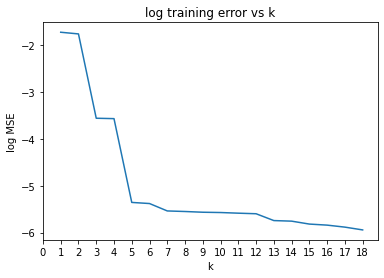

In [482]:
#calculate training MSE and plot
training_error = np.array([mse_test(X, g_X, k, f_map = sin_map) for k in range(1,19)]) #fit curve on X and calculate training MSE 
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(training_error))
ax.set_title('log training error vs k')
ax.set_ylabel('log MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
plt.show()

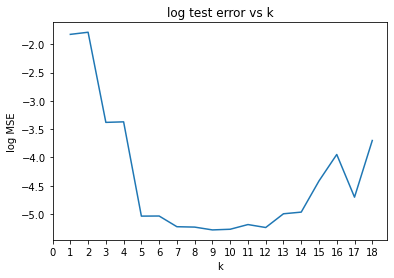

In [483]:
#Calculate test error and show
X_test = np.random.uniform(size = 1000)# generate test set
g_X_test = g(X_test, sig = 0.07) # generate y (g(X)) for test set
test_error = np.array([mse_test(X, g_X, k, X_test, g_X_test, f_map = sin_map) for k in range(1,19)])
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(test_error))

ax.set_title('log test error vs k')
ax.set_ylabel('log MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
plt.show()


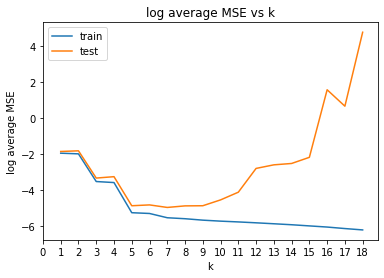

In [484]:
#average MSE for sin basis 
test_mse_avg = np.zeros(shape = (18,))
train_mse_avg = np.zeros(shape = (18,))
for iter in range(100):#for each run generate 30 training points, 1000 test points, fit curve for k = 1,...,18 on the training data, calculate training MSE then calculate MSE of fit on the test set
  X = np.random.uniform(size = 30)
  g_X = g(X, sig = 0.07)
  X_test = np.random.uniform(size = 1000) 
  g_X_test = g(X_test, 0.07)
  
  training_error = np.array([mse_test(X, g_X, k, f_map = sin_map) for k in range(1,19)]) # fit curves for different k and calculate training MSE 
  training_error /= 100 
  train_mse_avg += training_error 
  
  test_error = np.array([mse_test(X, g_X, k, X_test, g_X_test, f_map = sin_map) for k in range(1,19)]) # fit curves for different k on training set and calculate test MSE on test set
  test_error /= 100 
  test_mse_avg += test_error 

#plot results
fig, ax = plt.subplots()
ax.plot(list(range(1,19)), np.log(train_mse_avg), label = 'train')
ax.plot(list(range(1,19)), np.log(test_mse_avg), label = 'test')

ax.set_title('log average MSE vs k')
ax.set_ylabel('log average MSE')
ax.set_xlabel('k')
ax.set_xticks(list(range(19)))
ax.legend()
plt.show()

# 1.2) 4) - Boston House Prices

In [485]:
#download and format data
import pandas as pd 
url = 'http://www0.cs.ucl.ac.uk/staff/M.Herbster/boston-filter/Boston-filtered.csv'
df = pd.read_csv(url)
ds = df.to_numpy()
X = ds[:, :12] # take first 12 columns as X
y = ds[:, 12] # 13th column as y
m,n  = X.shape
bias = np.ones(shape = (m, 1)) # append column of 1's to the matrix which will be used as a bias feature. 
X = np.hstack([bias, X])


In [486]:
def tts(X,y):
  #splits data into train, test sets at 2/3, 1/3 

  if X.ndim == 1:
    X = X.reshape(m, 1)
  ind = np.arange(m, step = 1)
  train_ind = np.random.choice(ind, 2*m//3, replace = False) # sample indices for training randomly without replacement
  test_ind = ind[np.isin(ind, train_ind, invert = True)]#test indices are complement of training indices
  X_train = X[train_ind, :]
  X_test = X[test_ind, :]
  y_train = y[train_ind]
  y_test = y[test_ind]
  return X_train, y_train, X_test, y_test 


# 1.2) 4)a)



In [487]:

def linreg_mse(X_train, y_train, X_test, y_test, train_error = False):
    #fits linear regression model by solving least squares solution to w@X = y, then calculates the MSE of the fitted model on the test set
    w = np.linalg.lstsq(X_train, y_train,rcond=None)[0] 
    
    y_hat = np.array([w.T @ X_test[i,:] for i in range(X_test.shape[0])]).reshape(y_test.shape) # use solution w to predict on the test set

    MSE_test = np.sum((y_test - y_hat)**2)/X_test.shape[0] 

    if train_error:#if we also want the training error, return this too
        y_hat_train = np.array([w.T @ X_train[i,:] for i in range(X_train.shape[0])]).reshape(y_train.shape) #predict on the training set
        MSE_train = np.sum((y_train - y_hat_train)**2)/X_train.shape[0]
        return MSE_train, MSE_test
    else:
        return MSE_test

In [488]:
n_iter = 20
train_mse = []
test_mse = []
for _ in range(n_iter):#20 times fit curve for just the first (bias) column. Calculate training and test error. 
  X_train, y_train, X_test, y_test = tts(X[:,0], y) #only want the bias (first) column so take this from X and input into train test split function
  train, test  = linreg_mse(X_train, y_train, X_test, y_test, train_error = True) 
  train_mse.append(train)
  test_mse.append(test)
  
print(f'Average MSE for Naive Regression over 20 iterations. Train : {np.sum(train_mse)/n_iter}   Test : {np.sum(test_mse)/n_iter}')


Average MSE for Naive Regression over 20 iterations. Train : 82.62658273824724   Test : 88.24889256595097


#1.2) 4)b)

The constant function in 'a' predicts the mean of the y values in the training set. It is a prediction of yi given no information about xi. (X_transpose)@(X)  is equal to the number of samples in the training set. So ((X_transpose)@X)^-1(X_transpose)@Y = 1/m * sum(Y), which is the mean of Y. Please see report. 



# 1.2) 4)c)

In [489]:
n_iter = 20

for col in range(1, X.shape[1]): #for each column of the training set, 20 times fit curve for just the bias column and the other specific column. Calculate training and test error. 
  train_mse = [] 
  test_mse = []
  for _ in range(n_iter):
    X_train, y_train, X_test, y_test = tts(X[:,[0,col]], y) #train test split on the first column (bias) and one other column
    train, test  = linreg_mse(X_train, y_train, X_test, y_test, train_error = True) 
    train_mse.append(train)
    test_mse.append(test)
  print(f'Average MSE for Regression with attribute {col} over 20 iterations. Train : {np.sum(train_mse)/n_iter}   Test : {np.sum(test_mse)/n_iter}')


Average MSE for Regression with attribute 1 over 20 iterations. Train : 71.02926485305306   Test : 73.51233340943615
Average MSE for Regression with attribute 2 over 20 iterations. Train : 73.23315751767683   Test : 74.12392170482076
Average MSE for Regression with attribute 3 over 20 iterations. Train : 64.31725878118016   Test : 65.83302984363145
Average MSE for Regression with attribute 4 over 20 iterations. Train : 81.40531161114795   Test : 83.44384644048964
Average MSE for Regression with attribute 5 over 20 iterations. Train : 67.06410291418375   Test : 73.2718045263068
Average MSE for Regression with attribute 6 over 20 iterations. Train : 44.39466281582468   Test : 42.58088930958896
Average MSE for Regression with attribute 7 over 20 iterations. Train : 72.57533693978942   Test : 72.51609485776942
Average MSE for Regression with attribute 8 over 20 iterations. Train : 80.28053532854356   Test : 77.39883269940891
Average MSE for Regression with attribute 9 over 20 iterations. T

# 1.2) 4)d)

In [490]:
n_iter = 20
train_mse = []
test_mse = []
for _ in range(n_iter):#same as above but use all columns in X_train, including bias column
  X_train, y_train, X_test, y_test = tts(X, y)
  train, test  = linreg_mse(X_train, y_train, X_test, y_test, train_error = True)
  train_mse.append(train)
  test_mse.append(test)
print(f'Average MSE for Regression with all attributes over 20 iterations. Train : {np.sum(train_mse)/n_iter}   Test : {np.sum(test_mse)/n_iter}')

Average MSE for Regression with all attributes over 20 iterations. Train : 22.10790600307329   Test : 24.42270330554759


# 1.3) Kernelised Ridge Regression

In [491]:
X = ds[:, :12] # we take the original dataset again as we had added a bias column for other regressions 

In [492]:
X_train, y_train, X_test, y_test = tts(X,y) #create train and test splits 2/3 to 1/3 of data 

In [493]:
def gauss_kernel(X, xj, sig):
  #function for gaussian kernel with parameter sig
  #np.linalg.norm(X - xj) calculates the euclidean distance between a each point in X from a single point xj, returning a m by 1 vector of distances 
  return np.exp(- np.linalg.norm(X-xj, axis = 1)**2/(2 * sig**2))


In [494]:
def kernel_matrix(X, sigma = 1):
  #calculates m by m kernel matrix for a dataset X and sigma
  m = X.shape[0]
  K = np.zeros(shape = (m, m))
  for i in range(m):
    K[i,:] = gauss_kernel(X, X[i, :], sigma)

  return K


In [495]:
#create arrays of gammas and sigmas
gp = np.arange(-40, -25, step = 1)
sp = np.arange(7,13.5, step = .5)
gammas = np.array([2.0**i for i in gp])
sigmas = np.array([2.0**i for i in sp])

In [496]:
def kernel_pred(alpha,gamma, sigma, K, X_train, X_test):
  #given alpha, the solution to the kernelised least squares problem with X_train, y_train, gamma and sigma, make y_test predictions for test set X_test
  y_hat = []
  for xi in X_test:
    y_hati = alpha @ np.array(gauss_kernel(X_train, xi, sigma)) #evaluate kernel at test point and all training points, multiply with alpha to get predictions
    y_hat.append(y_hati)
  return np.array(y_hat)

In [497]:
def k_fold_cv(X, y, gamma, sigma, k):
  #splits the data into k folds, for each fold, fit a model which witholds that fold as the validation set, training on the other 4 folds. Average the MSE over the 5 test folds.
  m = X.shape[0]
  X_splits = np.split(X, [i*m//k for i in range(1,k)]) #Note that we get the same cross validation splits every time, meaning that all gamma, sigma pairs will be evaluated on the same splits for a given X_train, y_train
  y_splits = np.split(y, [i*m//k for i in range(1,k)])
  MSE_total = 0
  for fold in range(5):#iterate through each fold so each can be used as a validation set
    X_val = X_splits[fold]
    y_val = y_splits[fold]
    try:#concatenate the different training folds together to make a training set
      X_train = X_splits[:fold] +X_splits[fold+1:]
      y_train = y_splits[:fold] +y_splits[fold+1:]
    except:#to avoid index error on final fold
      X_train = X_splits[:fold]
      y_train = y_splits[:fold]
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    #now we calculate kernel matrix K, calculate alpha, and make predictions to get our error
    K = kernel_matrix(X_train, sigma) 
    alpha = np.linalg.lstsq(K + gamma*K.shape[0]*np.identity(K.shape[0]), y_train, rcond=None)[0] 
    y_hat = kernel_pred(alpha,gamma, sigma, K, X_train, X_val)
    MSE = np.sum((y_val - y_hat)**2)/X_val.shape[0]
    MSE_total += MSE
    

  #return our cross validation error as the average of the MSE's across the k folds
  return MSE_total/k 



# 1.3 5a)

In [498]:
#find the best pair of parameters sigma and gamma by performing kfold cross-validation on each combination of gamma, sigma

MSE = []
parameters = []
i = 0
for gamma in gammas:
  for sigma in sigmas:

     
    MSE.append(k_fold_cv(X_train, y_train, gamma, sigma, 5))#for each combination, get a MSE value from as the mean of the validation errors obtained in the k-fold cv performed
    parameters.append([gamma, sigma]) # keep track of pairs of parameters in a list
    i+=1

best_pair = parameters[np.array(MSE).argmin()] #find the pair of parameters with the corresponding lowest MSE 
print(best_pair)


[7.450580596923828e-09, 362.03867196751236]


#1.3 5b)  

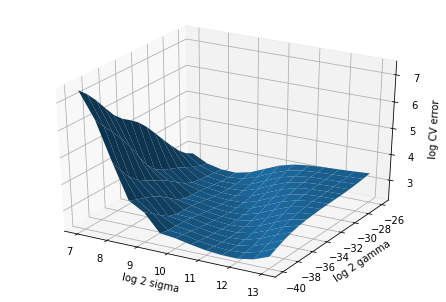

In [499]:
#plot CV error as a function of both gamma and sigma 

mse = np.array(np.log(MSE)).reshape(len(gammas), len(sigmas))
s, g= np.meshgrid(sp, gp)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(s, g, mse)
plt.xlabel('log 2 sigma')
plt.ylabel('log 2 gamma')
ax.set_zlabel('log CV error')
plt.show()

Text(0.5, 1.0, 'log CV error vs gamma and sigma')

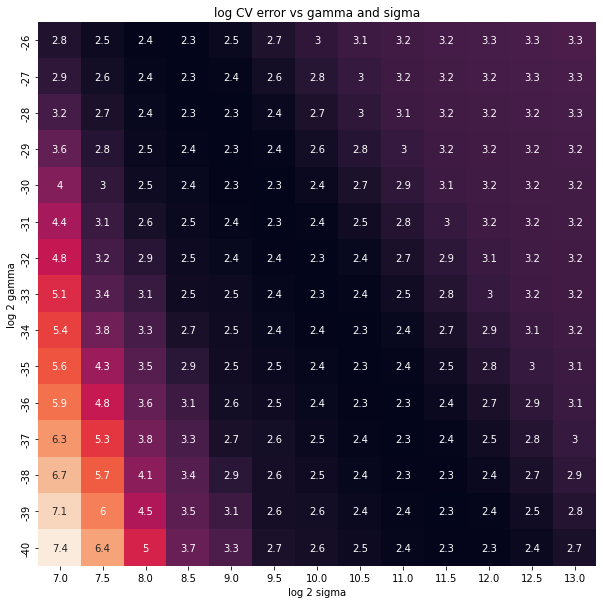

In [501]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(np.flip(mse, axis = 0), annot = True, xticklabels = sp, yticklabels = gp[::-1], cbar = False)
ax.set_xlabel('log 2 sigma', fontsize = 10)
ax.set_ylabel('log 2 gamma', fontsize = 10)
ax.set_title('log CV error vs gamma and sigma')

# 1.3 5c)

In [502]:
#now calculate train and test MSE on the training and test sets defined earlier, using the pair of gamma, sigma which we just found to minimise validation error.  

gamma = best_pair[0]
sigma = best_pair[1]
K = kernel_matrix(X_train, sigma)#first calculate kernel matrix
alpha = np.linalg.lstsq(K + gamma*K.shape[0]*np.identity(K.shape[0]), y_train, rcond=None)[0]  #solve least squares problem for alpha
y_hat_train = kernel_pred(alpha,gamma, sigma, K, X_train, X_train) #predict training set
y_hat_test = kernel_pred(alpha,gamma, sigma, K, X_train, X_test) #predict test set
MSE_train = np.sum((y_train - y_hat_train)**2)/X_train.shape[0]

MSE_test = np.sum((y_test - y_hat_test)**2)/X_test.shape[0]
print(f'Best MSE for Kernalised Ridge Regression. Train: {MSE_train} Test:{MSE_test}')

Best MSE for Kernalised Ridge Regression. Train: 6.8161166200200185 Test:14.620365342088581


# 1.3 5d)

In [503]:
bias = np.ones(shape = (m, 1)) # append column of 1's to the matrix which will be used as a bias feature. 
X = np.hstack([bias, X])

In [504]:
#create lists where we will store all our results for the table in the report
MSE_train = [] 
MSE_test = []
splits = [] # create 20 train test splits
for i in range(20):
  splits.append(tts(X,y))

In [505]:
#naive regression repeated 20 times with new train test splits each time, MSE recorded
n_iter = 20
all_mse_train = []
all_mse_test = []
for i in range(n_iter):
  
  #X_train, y_train, X_test, y_test = tts(X[:,0], y) # create new random train test split
  X_train, y_train, X_test, y_test = splits[i]
  mse_train, mse_test = linreg_mse(X_train[:,0].reshape(len(X_train), 1), y_train, X_test[:,0].reshape(len(X_test), 1), y_test, train_error = True)
  all_mse_train.append(mse_train)
  all_mse_test.append(mse_test)
MSE_train.append([np.mean(all_mse_train), np.std(all_mse_train)])
MSE_test.append([np.mean(all_mse_test), np.std(all_mse_test)])

In [506]:
#individual features with bias term regression repeated 20 times with new train test splits each time, MSE recorded
n_iter = 20
for col in range(1, X.shape[1]):
  mse = []

  all_mse_train = []
  all_mse_test = []
  for i in range(n_iter):
    
    #X_train, y_train, X_test, y_test = tts(X[:,[0,col]], y)
    X_train, y_train, X_test, y_test = splits[i]
    mse_train, mse_test = linreg_mse(X_train[:,[0,col]], y_train, X_test[:,[0,col]], y_test, train_error = True)
    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)
  MSE_train.append([np.mean(all_mse_train), np.std(all_mse_train)])
  MSE_test.append([np.mean(all_mse_test), np.std(all_mse_test)])

In [507]:
#all features with bias term repeated 20 times with new train test splits each time, MSE recorded
n_iter = 20
all_mse_train = []
all_mse_test = []
for i in range(n_iter):
  
  #X_train, y_train, X_test, y_test = tts(X, y)
  X_train, y_train, X_test, y_test = splits[i]
  mse_train, mse_test = linreg_mse(X_train, y_train, X_test, y_test, train_error = True)
  all_mse_train.append(mse_train)
  all_mse_test.append(mse_test)
MSE_train.append([np.mean(all_mse_train), np.std(all_mse_train)])
MSE_test.append([np.mean(all_mse_test), np.std(all_mse_test)])

In [508]:
#kernelised ridge regression using k-fold cross validation on 20 train test splits

X = ds[:, :12]#remove bias term for ridge regression again
all_mse_train = []
all_mse_test = []


n_iter = 20
ts = time.time()
for i in range(n_iter):
    
    X_train, y_train, X_test, y_test = tts(X, y) # select train test split
    MSE = []
    parameters = []
    #perform 5-fold cv on the training set 
    for gamma in gammas:
      for sigma in sigmas:
        MSE.append(k_fold_cv(X_train, y_train, gamma, sigma, 5))
        parameters.append([gamma, sigma])
  
    best_pair = parameters[np.array(MSE).argmin()] #find best pair gamma, sigma for this train test split by finding the index of the lowest MSE from cross validation
    gamma = best_pair[0]
    sigma = best_pair[1]
    #now fit our model and make predictions on the training set with this best pair of parameters
    K = kernel_matrix(X_train, sigma)
    alpha = np.linalg.lstsq(K + gamma*K.shape[0]*np.identity(K.shape[0]), y_train, rcond=None)[0] 
    
    y_hat_train = kernel_pred(alpha,gamma, sigma, K, X_train, X_train)
    mse_train = np.sum((y_train - y_hat_train)**2)/X_train.shape[0] 
    
    y_hat_test = kernel_pred(alpha,gamma, sigma, K, X_train, X_test)
    mse_test = np.sum((y_test - y_hat_test)**2)/X_test.shape[0]

    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)

MSE_train.append([np.mean(all_mse_train), np.std(all_mse_train)])
MSE_test.append([np.mean(all_mse_test), np.std(all_mse_test)])
print(f'Time Elapsed: {time.time() - ts} seconds')
print(f'Train mean : {np.mean(all_mse_train)} std : {np.std(all_mse_train)}' )
print(f'Test mean : {np.mean(all_mse_test)} std : {np.std(all_mse_test)}' )

Time Elapsed: 649.9977958202362 seconds
Train mean : 8.150167455496504 std : 0.9206745173784519
Tets mean : 12.889087924529965 std : 1.8849687704601226


In [509]:
print(MSE_train)

[[84.17322793191803, 4.233858396762995], [71.01715035000447, 3.682532938385473], [73.4470068856822, 3.664778535787916], [64.66512317739084, 3.8673806292142667], [81.1527063215114, 4.347933466904552], [68.98594966820335, 3.7885058877940487], [43.62736656992652, 2.945738888270762], [72.47824600328593, 4.190879135690619], [78.86695398647967, 4.138752786583098], [72.2552877359422, 3.8635373965380797], [65.87828720236821, 4.121024391971344], [63.00551661141729, 3.543692900788052], [38.08100779366833, 2.2024812510951643], [22.064671377308166, 1.7080740259211988], [8.150167455496504, 0.9206745173784519]]


In [510]:
print(MSE_test)

[[85.04665089799434, 8.461058876047467], [74.34331303035272, 8.923110558244245], [73.78821852898523, 7.393564807762919], [65.16814385516547, 7.682719462847287], [83.5867289331717, 8.710315269188905], [69.31386529642319, 7.570790517277539], [43.94413415012077, 5.7110696243928825], [72.61325247861618, 8.449144084549404], [80.05677043702893, 8.315736931509635], [72.37914187473719, 7.794058930436602], [66.40295426146285, 8.23484133704072], [62.357196883893174, 7.076433028519152], [39.496061037444704, 4.349329309014563], [24.373617522146937, 3.2691132063693833], [12.889087924529965, 1.8849687704601226]]
